In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from math import ceil
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier


### View the head of the df
- Drop a few insignificant columns
- Rename some entries of the "team name" column to match the "opponent" column

In [2]:
df = pd.read_csv('all_matches3.csv')
df.head()

,Unnamed: 0.1,Unnamed: 0,date,time,comp,round,day,venue,result,gf,...,crspa,prgp,sca,gca,crs,int,tklw,recov,season,team name
0,0,0,2023-08-13,16:30,Premier League,Matchweek 1,Sun,Away,D,1.0,...,2.0,34.0,24.0,2.0,12.0,10.0,9.0,62.0,2023,Liverpool
1,1,1,2023-08-19,15:00,Premier League,Matchweek 2,Sat,Home,W,3.0,...,0.0,40.0,40.0,4.0,16.0,11.0,11.0,58.0,2023,Liverpool
2,2,2,2023-08-27,16:30,Premier League,Matchweek 3,Sun,Away,W,2.0,...,0.0,26.0,16.0,3.0,16.0,8.0,7.0,42.0,2023,Liverpool
3,3,3,2023-09-03,14:00,Premier League,Matchweek 4,Sun,Home,W,3.0,...,1.0,41.0,32.0,2.0,13.0,8.0,9.0,56.0,2023,Liverpool
4,4,4,2023-09-16,12:30,Premier League,Matchweek 5,Sat,Away,W,3.0,...,4.0,73.0,30.0,4.0,18.0,9.0,16.0,57.0,2023,Liverpool


In [3]:
# Assuming df is your DataFrame

# Define the mapping of values to be replaced with their replacements
mapping = {
    "Manchester United": "Manchester Utd",
    "Brighton and Hove Albion": "Brighton",
    "Wolverhampton Wanderers": "Wolves",
    "West Ham United": "West Ham",
    "Newcastle United": "Newcastle Utd",
    "Tottenham Hotspur": "Tottenham",
    "Nottingham Forest": "Nott'ham Forest",
    "Sheffield United": "Sheffield Utd"
}

# Replace values in the 'team name' column using the defined mapping
df['team name'] = df['team name'].replace(mapping)

In [4]:
df = df.drop(df.columns[:2], axis=1)
print("Shape of the dataframe is",df.shape)

Shape of the dataframe is (2056, 46)


In [5]:
cols_to_drop = ['attendance',  'referee', 'match report', 'notes']
df = df.drop(columns=cols_to_drop)
df.shape

(2056, 42)

### Check NaN values and column dtypes

In [6]:
nan_values = df.isna().sum()
print("\nCount of NaN values in each column:")
print(nan_values)


Count of NaN values in each column:
date          0
time          0
comp          0
round         0
day           0
venue         0
result        0
gf            0
ga            0
opponent      0
xg            0
xga           0
poss          0
captain       0
formation     0
sh            0
sot           0
sot%          0
g/sh          0
g/sot        58
dist          0
fk            0
pk            0
pkatt         0
cmp           0
att           0
cmp%          0
totdist       0
prgdist       0
kp            0
1/3           0
ppa           0
crspa         0
prgp          0
sca           0
gca           0
crs           0
int           0
tklw          0
recov         0
season        0
team name     0
dtype: int64


In [7]:
print(df.dtypes)

date          object
time          object
comp          object
round         object
day           object
venue         object
result        object
gf           float64
ga           float64
opponent      object
xg           float64
xga          float64
poss         float64
captain       object
formation     object
sh           float64
sot          float64
sot%         float64
g/sh         float64
g/sot        float64
dist         float64
fk           float64
pk             int64
pkatt          int64
cmp          float64
att          float64
cmp%         float64
totdist      float64
prgdist      float64
kp           float64
1/3          float64
ppa          float64
crspa        float64
prgp         float64
sca          float64
gca          float64
crs          float64
int          float64
tklw         float64
recov        float64
season         int64
team name     object
dtype: object


In [8]:
# Peak into why the length of the df is the way it is 
print("Number of unique teams in our df =", df["team name"].nunique())
df["team name"].value_counts()

Number of unique teams in our df = 25


Liverpool          103
Manchester City    103
Arsenal            103
Aston Villa        103
Everton            103
Manchester Utd     103
West Ham           103
Newcastle Utd      103
Brighton           103
Wolves             103
Brentford          103
Crystal Palace     103
Chelsea            102
Tottenham          102
Leicester City      76
Southampton         76
Leeds United        76
Fulham              65
Nott'ham Forest     65
Burnley             65
Bournemouth         64
Watford             38
Norwich City        38
Sheffield Utd       27
Luton Town          26
Name: team name, dtype: int64

### Explanation of the above counts
- 20 teams play at the Premier League every season and each team plays 38 matches each season
- After 38 rounds of home and away leg fixtures, the last 3 teams, i.e the teams ranked 18th, 19th and 20th, are relegated to the Football League Championship.
- Their spots are taken by the top 2 teams from the Football League Championship and a 3rd team that qualifies after winning the play-offs involving the 3rd-6th placed teams of the Football League Championship!
- The data was scraped for 3 seasons including the current season which is ongoing
- Hence different teams have different number of matches, depending on what seasons they played and are playing 

### Converting some dtypes 

In [9]:
df["date"] = pd.to_datetime(df["date"])
df.head()

,date,time,comp,round,day,venue,result,gf,ga,opponent,...,crspa,prgp,sca,gca,crs,int,tklw,recov,season,team name
0,2023-08-13,16:30,Premier League,Matchweek 1,Sun,Away,D,1.0,1.0,Chelsea,...,2.0,34.0,24.0,2.0,12.0,10.0,9.0,62.0,2023,Liverpool
1,2023-08-19,15:00,Premier League,Matchweek 2,Sat,Home,W,3.0,1.0,Bournemouth,...,0.0,40.0,40.0,4.0,16.0,11.0,11.0,58.0,2023,Liverpool
2,2023-08-27,16:30,Premier League,Matchweek 3,Sun,Away,W,2.0,1.0,Newcastle Utd,...,0.0,26.0,16.0,3.0,16.0,8.0,7.0,42.0,2023,Liverpool
3,2023-09-03,14:00,Premier League,Matchweek 4,Sun,Home,W,3.0,0.0,Aston Villa,...,1.0,41.0,32.0,2.0,13.0,8.0,9.0,56.0,2023,Liverpool
4,2023-09-16,12:30,Premier League,Matchweek 5,Sat,Away,W,3.0,1.0,Wolves,...,4.0,73.0,30.0,4.0,18.0,9.0,16.0,57.0,2023,Liverpool


# Data Visualisation & Feature Engineering

### Creating meaningful features
- Some teams may play well during the day time, some may play night matches well

    - Create column "hour" out of date

- Convert venue(Categorical variable) to a numeric variable 

    - Use Label Encoding first then try out One hot encoding

In [10]:
venue_mapping = {'Home': 0, 'Away': 1}
df['venue_numeric'] = df['venue'].map(venue_mapping)

# Use label encoding to encode the opponent column
df['opponent_id'] = df['opponent'].astype('category').cat.codes

# Create column hour out of date
df["hour"] = df["time"].str.replace(":.+","", regex=True).astype("int")

### Creating the target feature [WIN = 1, DRAW/LOSE = 0]
- Here, we predict if a team would WIN or NOT WIN(LOSE/DRAW) i.e Binary classification problem
- Home team WIN = 1, DRAW/LOSE = 0

In [11]:
df["target"] = (df["result"] == "W").astype("int")
df.head()

,date,time,comp,round,day,venue,result,gf,ga,opponent,...,crs,int,tklw,recov,season,team name,venue_numeric,opponent_id,hour,target
0,2023-08-13,16:30,Premier League,Matchweek 1,Sun,Away,D,1.0,1.0,Chelsea,...,12.0,10.0,9.0,62.0,2023,Liverpool,1,6,16,0
1,2023-08-19,15:00,Premier League,Matchweek 2,Sat,Home,W,3.0,1.0,Bournemouth,...,16.0,11.0,11.0,58.0,2023,Liverpool,0,2,15,1
2,2023-08-27,16:30,Premier League,Matchweek 3,Sun,Away,W,2.0,1.0,Newcastle Utd,...,16.0,8.0,7.0,42.0,2023,Liverpool,1,16,16,1
3,2023-09-03,14:00,Premier League,Matchweek 4,Sun,Home,W,3.0,0.0,Aston Villa,...,13.0,8.0,9.0,56.0,2023,Liverpool,0,1,14,1
4,2023-09-16,12:30,Premier League,Matchweek 5,Sat,Away,W,3.0,1.0,Wolves,...,18.0,9.0,16.0,57.0,2023,Liverpool,1,24,12,1


## Data Visualisation
1. Home team win percent
- It is obvious that the number of wins should be equal to that of number of losses
- However, some teams play well at home conditions, hence the term home conditions

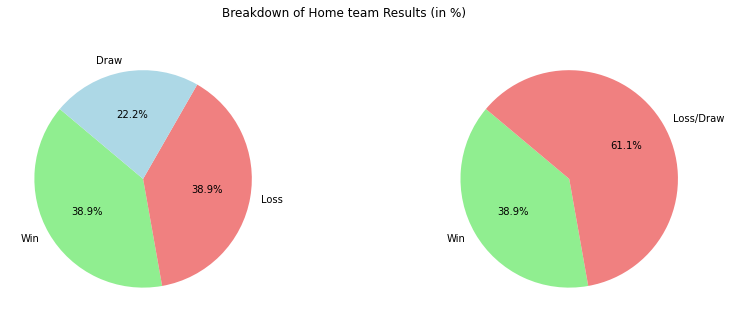

In [12]:
# Visualise the home team won %, draw or loss%
result_counts = df["result"].value_counts()
total_matches = df.shape[0]

win_percent = result_counts.get('W', 0)*100/total_matches
loss_percent = result_counts.get('L', 0)*100/total_matches
draw_percent = result_counts.get('D', 0)*100/total_matches
y1 = [win_percent, loss_percent, draw_percent]
labels1 = ["Win", "Loss", "Draw"]
colors_home1 = ['lightgreen', 'lightcoral', 'lightblue']

y2 = [win_percent, loss_percent + draw_percent]
labels2 = ["Win", "Loss/Draw"]
colors_home2 = ['lightgreen',  'lightcoral']


plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.pie(y1, labels = labels1, colors=colors_home1, autopct='%1.1f%%', startangle=140)

plt.subplot(1, 2, 2)
plt.pie(y2, labels = labels2, colors=colors_home2, autopct='%1.1f%%', startangle=140)
plt.suptitle("Breakdown of Home team Results (in %)")
plt.show() 

### 2. Check point biserial correlation
- The Point-Biserial Correlation is a special case of the Pearson Correlation and is used when you want to measure the relationship between a continuous variable and a dichotomous variable, or one that has two values (i.e. male/female, yes/no, true/false).


- Assumptions
    1. No outliers (continuous variable) - assessed through a visual examination of the scatterplot
    2. Approximately normally distributed (continuous variable)

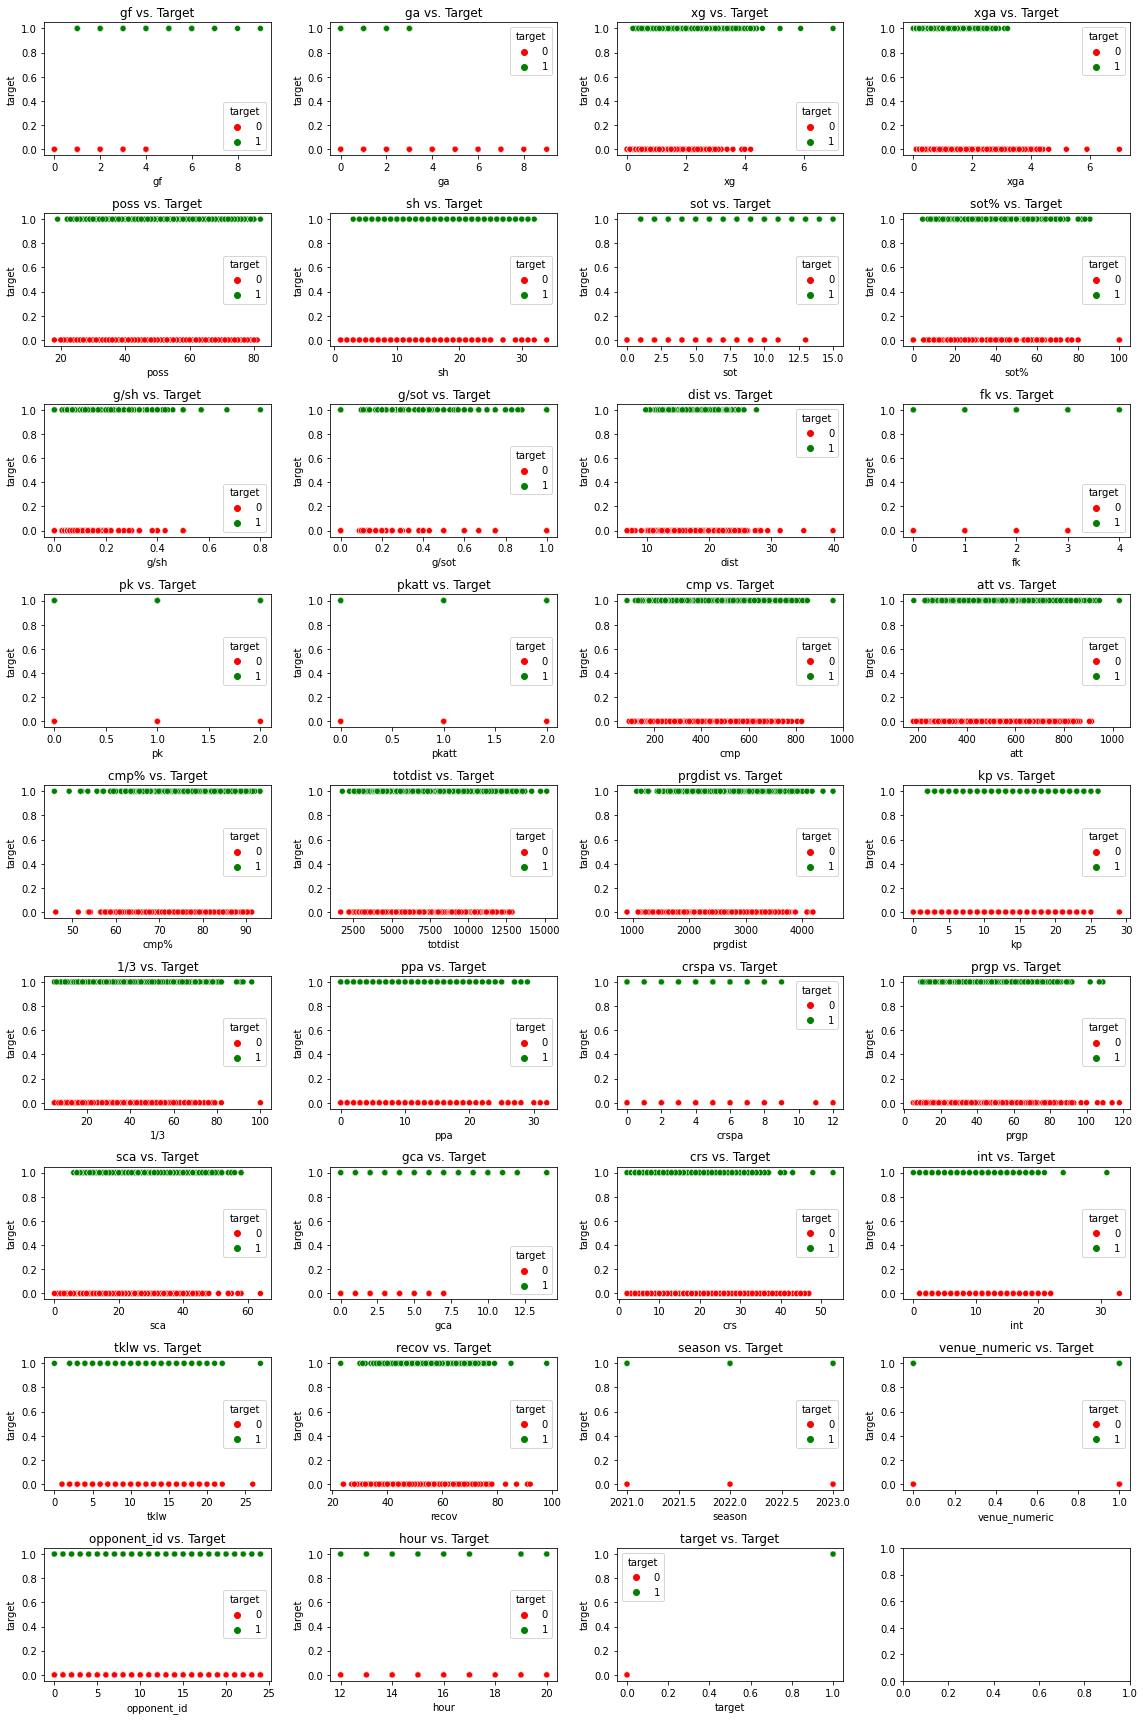

In [13]:
# Selecting only numerical features for demonstration
numerical_features = df.select_dtypes(include='number')

# Set up subplots with multiple rows
num_rows = 9
num_cols = ceil((len(numerical_features.columns) - 1)/num_rows) # Exclude 'target' column
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(16, 24))

axes = axes.flatten()

# Plot scatterplots for each numerical feature
for i, column in enumerate(numerical_features.columns):
    sns.scatterplot(x=column, y='target', data=df, ax=axes[i], hue='target', palette={0: 'red', 1: 'green'})
    axes[i].set_title(f'{column} vs. Target')

plt.tight_layout()
plt.show()

In [14]:
import pandas as pd
from scipy.stats import pointbiserialr

# Selecting only numerical features 
numerical_features = df.select_dtypes(include='number')

correlations = {}
for column in numerical_features.columns:
    if column != 'target':
    # Temporarily drop NaNs for each feature
        temp_df = df[[column, 'target']].dropna()
        corr, _ = pointbiserialr(temp_df[column], temp_df['target'])
        correlations[column] = round(corr, 2)

# Identifying features with correlation less than 0.08
irrelevant_features = [feature for feature, corr in correlations.items() if abs(corr) < 0.08]
print("\nIrrelevant Features: ", irrelevant_features)
correlations


Irrelevant Features:  ['fk', 'crspa', 'crs', 'int', 'tklw', 'season', 'opponent_id', 'hour']


{'gf': 0.65,
 'ga': -0.53,
 'xg': 0.45,
 'xga': -0.4,
 'poss': 0.17,
 'sh': 0.28,
 'sot': 0.42,
 'sot%': 0.23,
 'g/sh': 0.47,
 'g/sot': 0.41,
 'dist': -0.08,
 'fk': 0.06,
 'pk': 0.16,
 'pkatt': 0.14,
 'cmp': 0.2,
 'att': 0.19,
 'cmp%': 0.19,
 'totdist': 0.2,
 'prgdist': 0.21,
 'kp': 0.28,
 '1/3': 0.16,
 'ppa': 0.16,
 'crspa': -0.05,
 'prgp': 0.16,
 'sca': 0.28,
 'gca': 0.61,
 'crs': -0.07,
 'int': -0.07,
 'tklw': -0.02,
 'recov': 0.09,
 'season': 0.01,
 'venue_numeric': -0.14,
 'opponent_id': 0.05,
 'hour': -0.01}

In [15]:
# Drop the irrelevant features
cols_to_drop = ['fk', 'crspa', 'crs', 'int', 'tklw', 'hour']
df = df.drop(cols_to_drop, axis=1)    
df.shape

(2056, 40)

### Identifying Multicollinearity
- Plotting pair plot is too much time consuming and not much interpretable because of the presence of too many features and because the dataset is large
-  If you have many features, the number of scatter plots to be generated grows quadratically. 
- Can Try visualizing a subset of features initially.
- Or can us VIF 

In [16]:
X = df.select_dtypes(include='number')
X = X.drop(['target'], axis=1)
X = X.dropna()

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]


# Identify features with high VIF (e.g., VIF > 5)
high_vif_features = vif_data[vif_data['VIF'] > 5]['Feature'].tolist()

print("Features with High VIF:", high_vif_features)

Features with High VIF: ['gf', 'xg', 'xga', 'poss', 'sh', 'sot', 'sot%', 'g/sh', 'g/sot', 'dist', 'pk', 'pkatt', 'cmp', 'att', 'cmp%', 'totdist', 'prgdist', 'kp', '1/3', 'ppa', 'prgp', 'sca', 'gca', 'recov', 'season']


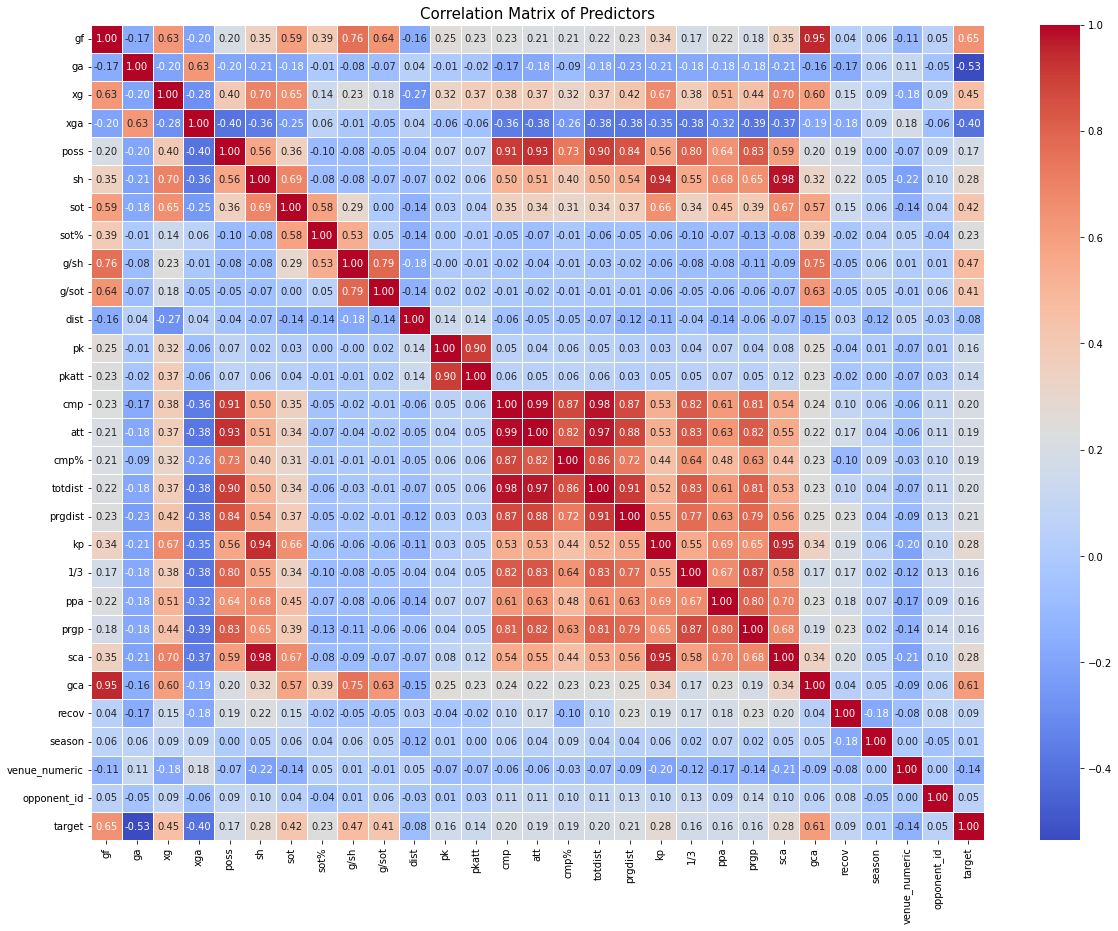

In [17]:
correlation_matrix = df.corr()

# Create a heatmap to visualize correlations
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Predictors", fontsize=15)
plt.show()

In [18]:
correlation_matrix.columns

Index(['gf', 'ga', 'xg', 'xga', 'poss', 'sh', 'sot', 'sot%', 'g/sh', 'g/sot',
       'dist', 'pk', 'pkatt', 'cmp', 'att', 'cmp%', 'totdist', 'prgdist', 'kp',
       '1/3', 'ppa', 'prgp', 'sca', 'gca', 'recov', 'season', 'venue_numeric',
       'opponent_id', 'target'],
      dtype='object')

In [19]:
# Check for pairs who has high correlation 
pairs = {}
threshold = 0.9
for i in range(correlation_matrix.shape[0]):
    for j in range(i + 1, correlation_matrix.shape[1]):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            pairs[(correlation_matrix.columns[i], correlation_matrix.columns[j])] = correlation_matrix.iloc[i, j]  
            
pairs

{('gf', 'gca'): 0.9484835034016612,
 ('poss', 'cmp'): 0.908384231251096,
 ('poss', 'att'): 0.931303478069184,
 ('poss', 'totdist'): 0.9009531866965288,
 ('sh', 'kp'): 0.9350777590501892,
 ('sh', 'sca'): 0.978287934238514,
 ('pk', 'pkatt'): 0.9008621620066507,
 ('cmp', 'att'): 0.9919547306448163,
 ('cmp', 'totdist'): 0.9785952959961917,
 ('att', 'totdist'): 0.9732312171074115,
 ('totdist', 'prgdist'): 0.9081836704536027,
 ('kp', 'sca'): 0.9480341667826748}

### Dropping some columns to mitigate multicollinearity

In [20]:
cols_to_drop = ["cmp", "att"]
filtered_pairs = {key: value for key, value in pairs.items() if "cmp" in key or "att" in key}
print(filtered_pairs)    
df = df.drop(cols_to_drop, axis=1)    
df.shape

{('poss', 'cmp'): 0.908384231251096, ('poss', 'att'): 0.931303478069184, ('cmp', 'att'): 0.9919547306448163, ('cmp', 'totdist'): 0.9785952959961917, ('att', 'totdist'): 0.9732312171074115}


(2056, 38)

In [21]:
df.columns

Index(['date', 'time', 'comp', 'round', 'day', 'venue', 'result', 'gf', 'ga',
       'opponent', 'xg', 'xga', 'poss', 'captain', 'formation', 'sh', 'sot',
       'sot%', 'g/sh', 'g/sot', 'dist', 'pk', 'pkatt', 'cmp%', 'totdist',
       'prgdist', 'kp', '1/3', 'ppa', 'prgp', 'sca', 'gca', 'recov', 'season',
       'team name', 'venue_numeric', 'opponent_id', 'target'],
      dtype='object')

### Visualise Home win percentage V/s Away Win percentage
- The visualisation shows that certain teams play better at home/away
- So, we need to incorporate some feature which captures this
- They can be 
    - Avg number of home wins of the home team in the last 10 or 15 matches
    - Avg number of away wins of the away team in the last 10 or 15 matches 

Text(0.5, 0, 'Win Percentage (%)')

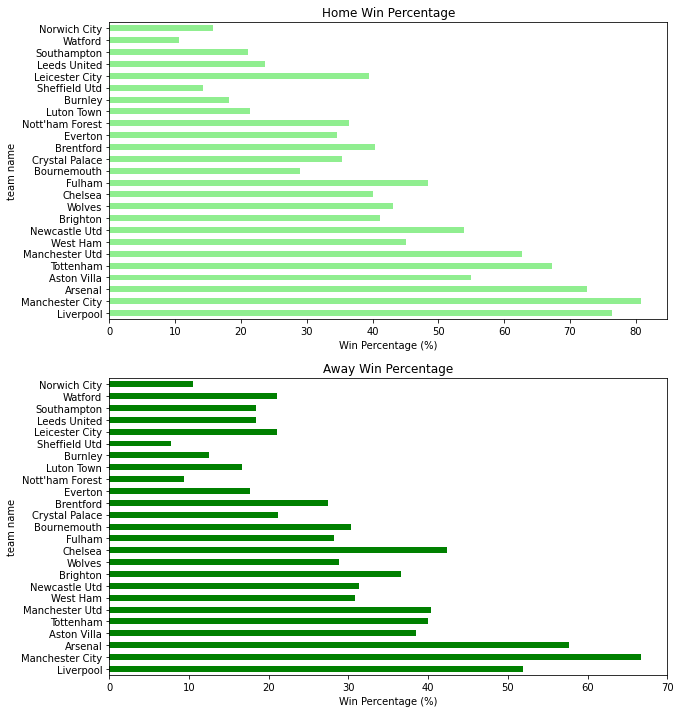

In [22]:
# Create subsets for Home and Away
temp_df1 = df[df["venue"] == 'Home'].copy()
temp_df2 = df[df["venue"] == 'Away'].copy()

# Calculate Home and Away Win Percentages
temp_df1.loc[:, 'home_win_percentage'] = temp_df1.groupby('team name')['target'].transform('mean') * 100
temp_df2.loc[:, 'away_win_percentage'] = temp_df2.groupby('team name')['target'].transform('mean') * 100

# Calculate Goals Scored and Conceded at Home and Away
temp_df1.loc[:, 'goals_scored_home'] = temp_df1.groupby('team name')['gf'].transform('sum')
temp_df1.loc[:, 'goals_conceded_home'] = temp_df1.groupby('team name')['ga'].transform('sum')
temp_df2.loc[:, 'goals_scored_away'] = temp_df2.groupby('team name')['gf'].transform('sum')
temp_df2.loc[:, 'goals_conceded_away'] = temp_df2.groupby('team name')['ga'].transform('sum')

# Plotting Horizontal Bar Charts
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))

# Home Win Percentage
temp_df1.drop_duplicates(subset=['team name']).plot(kind='barh', x='team name', y='home_win_percentage',
                                               ax=axes[0], color='lightgreen', legend=False)
axes[0].set_title('Home Win Percentage')
axes[0].set_xlabel('Win Percentage (%)')

# Away Win Percentage
temp_df2.drop_duplicates(subset=['team name']).plot(kind='barh', x='team name', y='away_win_percentage',
                                               ax=axes[1], color='green', legend=False)
axes[1].set_title('Away Win Percentage')
axes[1].set_xlabel('Win Percentage (%)')



### Visualise Home Goals scored/conceded V/s Away Goals scored/conceded
- The visualisation shows that certain teams score better at home/away
- So, we need to incorporate some feature which captures this
- They can be 
    - Number of goals scored and conceded by the home team in the last 10 Home matches
    - Number of goals scored and conceded by the away team in the last 10 Away matches

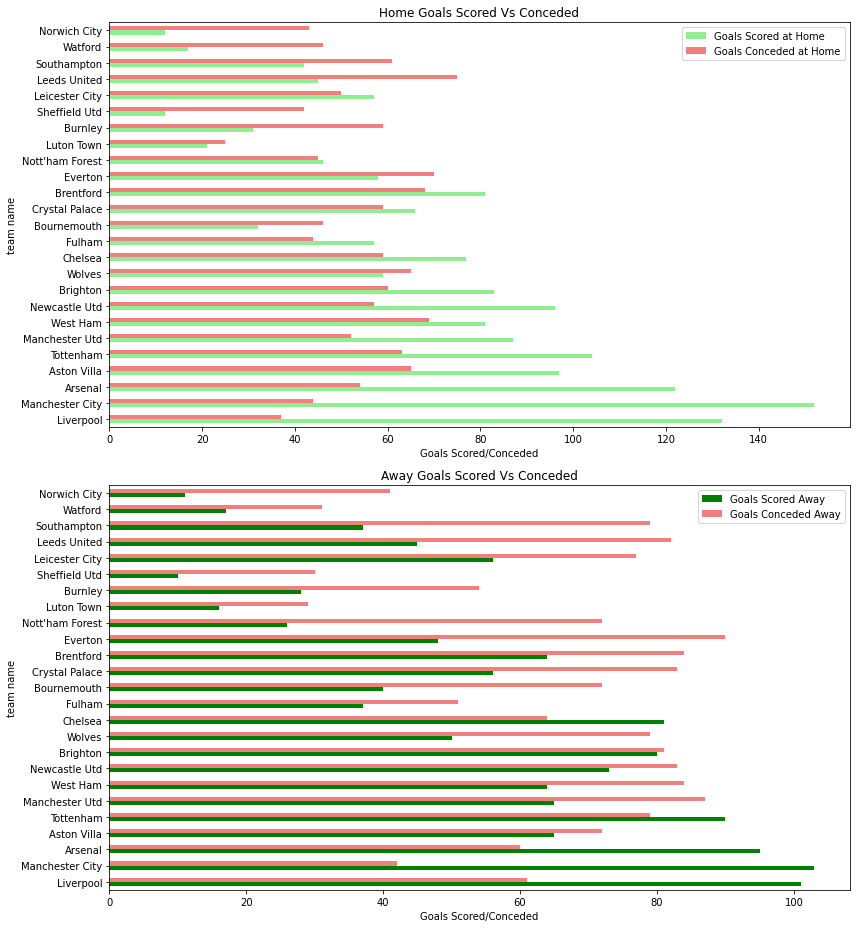

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 13))

temp_df1.drop_duplicates(subset=['team name']).plot(kind='barh', x='team name', y=['goals_scored_home', 'goals_conceded_home'],
                                               ax=axes[0], color=['lightgreen', 'lightcoral'])
axes[0].legend(['Goals Scored at Home', 'Goals Conceded at Home'])
axes[0].set_title('Home Goals Scored Vs Conceded')
axes[0].set_xlabel('Goals Scored/Conceded')


temp_df2.drop_duplicates(subset=['team name']).plot(kind='barh', x='team name', y=['goals_scored_away', 'goals_conceded_away'],
                                               ax=axes[1], color=['green', 'lightcoral'])
axes[1].legend(['Goals Scored Away', 'Goals Conceded Away'])
axes[1].set_title('Away Goals Scored Vs Conceded')
axes[1].set_xlabel('Goals Scored/Conceded')

plt.tight_layout()
plt.show()

In [24]:
# All of Chelsea's Home matches
print(temp_df1[temp_df1['team name'] == "Chelsea"].shape)
temp_df1[temp_df1['team name'] == "Chelsea"].head()

(50, 41)


,date,time,comp,round,day,venue,result,gf,ga,opponent,...,gca,recov,season,team name,venue_numeric,opponent_id,target,home_win_percentage,goals_scored_home,goals_conceded_home
269,2023-08-13,16:30,Premier League,Matchweek 1,Sun,Home,D,1.0,1.0,Liverpool,...,2.0,63.0,2023,Chelsea,0,12,0,40.0,77.0,59.0
271,2023-08-25,20:00,Premier League,Matchweek 3,Fri,Home,W,3.0,0.0,Luton Town,...,6.0,47.0,2023,Chelsea,0,13,1,40.0,77.0,59.0
272,2023-09-02,15:00,Premier League,Matchweek 4,Sat,Home,L,0.0,1.0,Nott'ham Forest,...,0.0,54.0,2023,Chelsea,0,18,0,40.0,77.0,59.0
274,2023-09-24,14:00,Premier League,Matchweek 6,Sun,Home,L,0.0,1.0,Aston Villa,...,0.0,59.0,2023,Chelsea,0,1,0,40.0,77.0,59.0
277,2023-10-21,17:30,Premier League,Matchweek 9,Sat,Home,D,2.0,2.0,Arsenal,...,2.0,59.0,2023,Chelsea,0,0,0,40.0,77.0,59.0


## Verifying
- There are duplicate entries for every match of each team meaning
- There are 2 entries for each match, one corresponding to team A and the other w.r.t. team B 

In [25]:
df = df.sort_values("date")
print(df[(df["venue"] == "Away") & (df["team name"] == "Liverpool")].shape)
df[(df["venue"] == "Away") & (df["team name"] == "Liverpool")].head()

(52, 38)


,date,time,comp,round,day,venue,result,gf,ga,opponent,...,ppa,prgp,sca,gca,recov,season,team name,venue_numeric,opponent_id,target
1334,2021-08-14,17:30,Premier League,Matchweek 1,Sat,Away,W,3.0,0.0,Norwich City,...,12.0,47.0,32.0,5.0,52.0,2021,Liverpool,1,17,1
1337,2021-09-12,16:30,Premier League,Matchweek 4,Sun,Away,W,3.0,0.0,Leeds United,...,9.0,47.0,56.0,5.0,59.0,2021,Liverpool,1,10,1
1339,2021-09-25,17:30,Premier League,Matchweek 6,Sat,Away,D,3.0,3.0,Brentford,...,18.0,45.0,27.0,6.0,47.0,2021,Liverpool,1,3,0
1341,2021-10-16,12:30,Premier League,Matchweek 8,Sat,Away,W,5.0,0.0,Watford,...,10.0,60.0,34.0,8.0,61.0,2021,Liverpool,1,22,1
1342,2021-10-24,16:30,Premier League,Matchweek 9,Sun,Away,W,5.0,0.0,Manchester Utd,...,7.0,54.0,32.0,9.0,54.0,2021,Liverpool,1,15,1


In [26]:
# Extract all matches where venue was HOME and opponent was LIVERPOOL
# => Liverpool was playing AWAY game
print(df[(df["venue"] == "Home") & (df["opponent"] == "Liverpool")].shape)
df[(df["venue"] == "Home") & (df["opponent"] == "Liverpool")].head()

(52, 38)


,date,time,comp,round,day,venue,result,gf,ga,opponent,...,ppa,prgp,sca,gca,recov,season,team name,venue_numeric,opponent_id,target
2018,2021-08-14,17:30,Premier League,Matchweek 1,Sat,Home,L,0.0,3.0,Liverpool,...,6.0,29.0,22.0,0.0,51.0,2021,Norwich City,0,12,0
1907,2021-09-12,16:30,Premier League,Matchweek 4,Sun,Home,L,0.0,3.0,Liverpool,...,7.0,29.0,16.0,0.0,45.0,2021,Leeds United,0,12,0
1757,2021-09-25,17:30,Premier League,Matchweek 6,Sat,Home,D,3.0,3.0,Liverpool,...,8.0,27.0,19.0,4.0,38.0,2021,Brentford,0,12,0
1987,2021-10-16,12:30,Premier League,Matchweek 8,Sat,Home,L,0.0,5.0,Liverpool,...,3.0,14.0,9.0,0.0,62.0,2021,Watford,0,12,0
1494,2021-10-24,16:30,Premier League,Matchweek 9,Sun,Home,L,0.0,5.0,Liverpool,...,6.0,31.0,24.0,0.0,53.0,2021,Manchester Utd,0,12,0


### Create Rolling averages for features which are available for  past matches but NOT the to-predict match 
- 

In [27]:
def compute_rolling_averages(df, columns, window_size, new_column_suffix='_rolling_avg', home=True):
    """
    Compute rolling averages for specific columns in a pandas DataFrame and assign them to new columns in the same DataFrame.

    Parameters:
    df (pandas DataFrame): The input DataFrame.
    columns (list of str): The names of the columns to compute rolling averages for.
    window_size (int): The size of the rolling window.
    new_column_suffix (str, optional): The suffix to append to the names of the new columns. Defaults to '_rolling_avg'.

    Returns:
    pandas DataFrame: The updated DataFrame with the rolling average columns.
                                                                                                                """
    
    # Sort if already not sorted
    df = df.sort_values("date")
    new_column_names = []
    
    for column in columns:
        new_column_name = column + new_column_suffix
        new_column_names.append(new_column_name)
        
        # Calculate rolling averages with available rows if less than window size
        df.loc[:, new_column_name] = df[column].rolling(min_periods=1, window=window_size, closed='left').mean()
    
    df = df.dropna(subset=new_column_names)
    
    return df


In [28]:
df.columns

Index(['date', 'time', 'comp', 'round', 'day', 'venue', 'result', 'gf', 'ga',
       'opponent', 'xg', 'xga', 'poss', 'captain', 'formation', 'sh', 'sot',
       'sot%', 'g/sh', 'g/sot', 'dist', 'pk', 'pkatt', 'cmp%', 'totdist',
       'prgdist', 'kp', '1/3', 'ppa', 'prgp', 'sca', 'gca', 'recov', 'season',
       'team name', 'venue_numeric', 'opponent_id', 'target'],
      dtype='object')

In [29]:
# # Define different cols_list since there are 2 different window sizes
cols_list = ["gf", "ga", "sh", "sot", "sot%" , "g/sh", "g/sot", "dist", "pk", "pkatt", "poss", "xg", "xga", 'cmp%', 'totdist','prgdist', 'kp', '1/3', 'ppa', 'prgp', 'sca', 'gca', 'recov']

In [30]:
grouped_df = df.groupby("team name") 
man_city_group = grouped_df.get_group("Manchester City").sort_values("date")
man_city_group

,date,time,comp,round,day,venue,result,gf,ga,opponent,...,ppa,prgp,sca,gca,recov,season,team name,venue_numeric,opponent_id,target
1296,2021-08-15,16:30,Premier League,Matchweek 1,Sun,Away,L,0.0,1.0,Tottenham,...,9.0,58.0,35.0,0.0,53.0,2021,Manchester City,1,21,0
1297,2021-08-21,15:00,Premier League,Matchweek 2,Sat,Home,W,5.0,0.0,Norwich City,...,17.0,75.0,28.0,7.0,38.0,2021,Manchester City,0,17,1
1298,2021-08-28,12:30,Premier League,Matchweek 3,Sat,Home,W,5.0,0.0,Arsenal,...,21.0,69.0,49.0,10.0,45.0,2021,Manchester City,0,0,1
1299,2021-09-11,15:00,Premier League,Matchweek 4,Sat,Away,W,1.0,0.0,Leicester City,...,18.0,76.0,42.0,1.0,53.0,2021,Manchester City,1,11,1
1300,2021-09-18,15:00,Premier League,Matchweek 5,Sat,Home,D,0.0,0.0,Southampton,...,11.0,42.0,31.0,0.0,51.0,2021,Manchester City,0,20,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49,2024-02-10,12:30,Premier League,Matchweek 24,Sat,Home,W,2.0,0.0,Everton,...,6.0,52.0,35.0,3.0,42.0,2023,Manchester City,0,8,1
50,2024-02-17,17:30,Premier League,Matchweek 25,Sat,Home,D,1.0,1.0,Chelsea,...,25.0,82.0,54.0,1.0,45.0,2023,Manchester City,0,6,0
51,2024-02-20,19:30,Premier League,Matchweek 18,Tue,Home,W,1.0,0.0,Brentford,...,24.0,73.0,45.0,2.0,35.0,2023,Manchester City,0,3,1
52,2024-02-24,17:30,Premier League,Matchweek 26,Sat,Away,W,1.0,0.0,Bournemouth,...,11.0,47.0,28.0,1.0,52.0,2023,Manchester City,1,2,1


In [31]:
compute_rolling_averages(man_city_group, cols_list, 5).head()

,date,time,comp,round,day,venue,result,gf,ga,opponent,...,cmp%_rolling_avg,totdist_rolling_avg,prgdist_rolling_avg,kp_rolling_avg,1/3_rolling_avg,ppa_rolling_avg,prgp_rolling_avg,sca_rolling_avg,gca_rolling_avg,recov_rolling_avg
1297,2021-08-21,15:00,Premier League,Matchweek 2,Sat,Home,W,5.0,0.0,Norwich City,...,81.900000,7528.000000,2608.000000,13.0,40.000000,9.000000,58.000000,35.000000,0.000000,53.000000
1298,2021-08-28,12:30,Premier League,Matchweek 3,Sat,Home,W,5.0,0.0,Arsenal,...,86.350000,9680.000000,2822.500000,12.0,58.500000,13.000000,66.500000,31.500000,3.500000,45.500000
1299,2021-09-11,15:00,Premier League,Matchweek 4,Sat,Away,W,1.0,0.0,Leicester City,...,87.133333,10029.666667,2950.666667,15.0,56.333333,15.666667,67.333333,37.333333,5.666667,45.333333
1300,2021-09-18,15:00,Premier League,Matchweek 5,Sat,Home,D,0.0,0.0,Southampton,...,87.000000,9833.750000,2909.000000,15.5,56.000000,16.250000,69.500000,38.500000,4.500000,47.250000
1301,2021-09-25,12:30,Premier League,Matchweek 6,Sat,Away,W,1.0,0.0,Chelsea,...,86.620000,9619.000000,2929.600000,14.8,51.200000,15.200000,64.000000,37.000000,3.600000,48.000000


In [32]:
all_matches_rolling = df.groupby("team name").apply(lambda x: compute_rolling_averages(x, cols_list, 3))
all_matches_rolling.index = range(all_matches_rolling.shape[0])
all_matches_rolling.shape

(2029, 61)

In [33]:
def predict(train_data, test_data, features, model):
    """
     Fits the model on the training data using the specified features and target column, makes predictions on the test data.
     It then creates a pandas DataFrame that contains both the actual target values and the predicted target values, 
     with the index set to the index of the test data. Computes the precision score as well.
     
    Args:
        train_data: a pandas DataFrame containing the training data
        test_data: a pandas DataFrame containing the testing data
        features: a list of strings containing the names of the features to use 
        model: a machine learning model object with a fit() and predict() method.
    
    Returns:
        error: precision score
        combined: a pandas df that contains both the actual target values and the predicted target values
        accuracy: accuracy score
                                                                                                                        """
    model.fit(train_data[features], train_data["target"])
    preds = model.predict(test_data[features])
    combined = pd.DataFrame(dict(actual=test_data["target"], predicted=preds), index=test_data.index)
    precision = precision_score(test_data["target"], preds)
    accuracy = accuracy_score(test_data["target"], preds)
        
    return combined, precision, accuracy

### Train-test split

In [34]:
######### Train- test data #########

train_data = all_matches_rolling[all_matches_rolling["date"] < '2023-12-30']
test_data = all_matches_rolling[all_matches_rolling["date"] >= '2023-12-30']
print(f"Shape of our training data is {train_data.shape}")
print(f"Shape of our testing data is {test_data.shape}")
team_counts = test_data['team name'].value_counts()
print(team_counts)


####### Preparing the new features #########
new_columns = []
for column in cols_list:
    new_column_name = column + '_rolling_avg'
    new_columns.append(new_column_name)
    
features = ["venue_numeric", "opponent_id"]
new_features = features + new_columns

Shape of our training data is (1869, 61)
Shape of our testing data is (160, 61)
Brentford          9
Manchester City    9
Arsenal            8
Aston Villa        8
West Ham           8
Sheffield Utd      8
Nott'ham Forest    8
Newcastle Utd      8
Manchester Utd     8
Luton Town         8
Liverpool          8
Fulham             8
Everton            8
Crystal Palace     8
Burnley            8
Brighton           8
Bournemouth        8
Wolves             8
Chelsea            7
Tottenham          7
Name: team name, dtype: int64


In [35]:
# Deining a random forest model
rf_model = RandomForestClassifier(n_estimators=50, min_samples_split=2, random_state=6)  

combined, precision, accuracy = predict(train_data, test_data, new_features, rf_model)
print(f"Accuracy: {accuracy} \n Precision: {precision}")

Accuracy: 0.65 
 Precision: 0.5853658536585366


In [36]:
# Create a SVM classifier with the Gaussian kernel
clf_model = SVC(kernel='rbf')


# create a Gradient Boosting Classifier model
gb_model = GradientBoostingClassifier(n_estimators=35, max_depth=3, learning_rate=0.1)


# LIST OF MODELS
models = [rf_model, clf_model, gb_model]
combined_df_list = []


for model in models:
    combined, precision, accuracy = predict(train_data, test_data, features + new_columns, model)
    combined_df_list.append(combined)
    print(f"Precision score using the model {model} = {precision}")
    print(f"Accuracy score using the model {model} = {accuracy}")
    print("\n")
        

Precision score using the model RandomForestClassifier(n_estimators=50, random_state=6) = 0.5853658536585366
Accuracy score using the model RandomForestClassifier(n_estimators=50, random_state=6) = 0.65


Precision score using the model SVC() = 0.7142857142857143
Accuracy score using the model SVC() = 0.64375


Precision score using the model GradientBoostingClassifier(n_estimators=35) = 0.6818181818181818
Accuracy score using the model GradientBoostingClassifier(n_estimators=35) = 0.70625




In [37]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score

# Define the parameter grid for tuning
param_grid = {
    'learning_rate': [0.01, 0.1, 0.5, 1],
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1],
    'n_estimators': [100, 500, 1000, 2000]
}

# Create an XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='binary:logistic', seed=42)

# Perform a random search for the best hyperparameters
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=50,
    scoring='roc_auc',
    cv=5,
    verbose=1,
    random_state=42
)

# Fit the random search to the data
random_search.fit(train_data[new_features], train_data["target"])

# Print the best hyperparameters and the AUC score
print("Best Hyperparameters:", random_search.best_params_)
print("AUC Score:", random_search.best_score_)



Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Hyperparameters: {'subsample': 1, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
AUC Score: 0.6710137978585977


In [38]:
# use the best hyperparameters to train a final model on the entire training data
best_model = xgb.XGBClassifier(**random_search.best_params_)
best_model.fit(train_data[new_features], train_data["target"])

# use the final model to make predictions on the test data
preds = best_model.predict(test_data[new_features])

# evaluate the final model using the AUC score
auc_score = roc_auc_score(test_data["target"], preds)
print("AUC score:", auc_score)
print("Precision Score:", precision_score(test_data["target"], preds))
print("Accuracy Score:", accuracy_score(test_data["target"], preds))
                                

AUC score: 0.6607756504663721
Precision Score: 0.6666666666666666
Accuracy Score: 0.7


### Create some helper columns
- Avg Number of home team wins in the last 5 HOME matches & Avg Number of away team's AWAY match wins
- Goal difference = 'gd'
- Avg number of goals scored & conceded at home for HOME TEAM => "gd_home"
- Avg number of goals scored & conceded AWAY for AWAY TEAM => "gd_away"

In [39]:
def calculate_wins(df, window_size=5):
    df = df.sort_values(by=['date', 'time'], ascending=[False, False])
    df['wins_away'] = 0
    df['wins_home'] = 0

    for index, row in df.iterrows():
        date_mask = (df['date'] < row['date'])
        time_mask = (df['date'] == row['date']) & (df['time'] < row['time'])

        if row['venue'] == 'Home':
            edit_df = df[(df['team name'] == row['team name']) & (df['venue'] == row['venue']) & (date_mask | time_mask)]
            df.at[index, 'wins_home'] = edit_df['result'].head(window_size).value_counts().get('W', 0)

            edit_df = df[(df['team name'] == row['opponent']) & (df['venue'] == 'Away') & (date_mask | time_mask)]
            df.at[index, 'wins_away'] = edit_df['result'].head(window_size).value_counts().get('W', 0)

        else:
            edit_df = df[(df['team name'] == row['team name']) & (df['venue'] == row['venue']) & (date_mask | time_mask)]
            df.at[index, 'wins_away'] = edit_df['result'].head(window_size).value_counts().get('W', 0)

            edit_df = df[(df['team name'] == row['opponent']) & (df['venue'] == 'Home') & (date_mask | time_mask)]
            df.at[index, 'wins_home'] = edit_df['result'].head(window_size).value_counts().get('W', 0)

    return df

In [40]:
new_df = all_matches_rolling
new_df = calculate_wins(new_df)

In [41]:
new_df.shape

(2029, 63)

#### Create a new column "gd" for goal difference

In [42]:
new_df['gd'] = new_df['gf'] - new_df['ga']
new_df.shape

(2029, 64)

In [43]:
def calculate_goal_difference(df, window_size=5):
    df = df.sort_values(by=['date', 'time'], ascending=[False, False])

    df['gd_away'] = 0
    df['gd_home'] = 0

    for index, row in df.iterrows():
        date_mask = (df['date'] < row['date'])
        time_mask = (df['date'] == row['date']) & (df['time'] < row['time'])

        if row['venue'] == 'Home':
            edit_df = df[(df['team name'] == row['team name']) & (df['venue'] == row['venue']) & (date_mask | time_mask)]
            df.at[index, 'gd_home'] = edit_df['gd'].head(window_size).sum()

            edit_df = df[(df['team name'] == row['opponent']) & (df['venue'] == 'Away') & (date_mask | time_mask)]
            df.at[index, 'gd_away'] = edit_df['gd'].head(window_size).sum()

        else:
            edit_df = df[(df['team name'] == row['team name']) & (df['venue'] == row['venue']) & (date_mask | time_mask)]
            df.at[index, 'gd_away'] = edit_df['gd'].head(window_size).sum()

            edit_df = df[(df['team name'] == row['opponent']) & (df['venue'] == 'Home') & (date_mask | time_mask)]
            df.at[index, 'gd_home'] = edit_df['gd'].head(window_size).sum()

    return df

In [44]:
new_df = calculate_goal_difference(new_df)
new_df.shape

(2029, 66)

In [45]:
######### Train- test data #########

train_data = new_df[new_df["date"] < '2023-12-30']
test_data = new_df[new_df["date"] >= '2023-12-30']
print(f"Shape of our training data is {train_data.shape}")
print(f"Shape of our testing data is {test_data.shape}\n")

Shape of our training data is (1869, 66)
Shape of our testing data is (160, 66)



In [46]:
# Add the new features in our features list
to_add_features = ["wins_home", "wins_away", "gd_home", "gd_away"]
new_features.extend(to_add_features)
print(new_features)

['venue_numeric', 'opponent_id', 'gf_rolling_avg', 'ga_rolling_avg', 'sh_rolling_avg', 'sot_rolling_avg', 'sot%_rolling_avg', 'g/sh_rolling_avg', 'g/sot_rolling_avg', 'dist_rolling_avg', 'pk_rolling_avg', 'pkatt_rolling_avg', 'poss_rolling_avg', 'xg_rolling_avg', 'xga_rolling_avg', 'cmp%_rolling_avg', 'totdist_rolling_avg', 'prgdist_rolling_avg', 'kp_rolling_avg', '1/3_rolling_avg', 'ppa_rolling_avg', 'prgp_rolling_avg', 'sca_rolling_avg', 'gca_rolling_avg', 'recov_rolling_avg', 'wins_home', 'wins_away', 'gd_home', 'gd_away']


In [47]:
# Deining a random forest model
rf_model = RandomForestClassifier(n_estimators=50, min_samples_split=2, random_state=6)  

# Create a SVM classifier with the Gaussian kernel
clf_model = SVC(kernel='rbf')

# create a Gradient Boosting Classifier model
gb_model = GradientBoostingClassifier(n_estimators=100, max_depth=1, learning_rate=0.1)


# Create a Naive Bayes classifier
nb_model = GaussianNB()

# List of models
models = [rf_model, clf_model, gb_model, nb_model]
combined_df_list = []


for model in models:
    combined, precision, accuracy = predict(train_data, test_data, new_features, model)
    combined_df_list.append(combined)
    print(f"Precision score using the model {model} = {precision}")
    print(f"Accuracy score using the model {model} = {accuracy}")
    print("\n")

Precision score using the model RandomForestClassifier(n_estimators=50, random_state=6) = 0.5777777777777777
Accuracy score using the model RandomForestClassifier(n_estimators=50, random_state=6) = 0.65


Precision score using the model SVC() = 0.7142857142857143
Accuracy score using the model SVC() = 0.64375


Precision score using the model GradientBoostingClassifier(max_depth=1) = 0.7777777777777778
Accuracy score using the model GradientBoostingClassifier(max_depth=1) = 0.73125




In [48]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score

# Define the parameter grid for tuning
param_grid = {
    'learning_rate': [0.01, 0.1, 0.5, 1],
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1],
    'n_estimators': [100, 500, 1000, 2000]
}

# Create an XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='binary:logistic', seed=42)

# Perform a random search for the best hyperparameters
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=50,
    scoring='roc_auc',
    cv=5,
    verbose=1,
    random_state=42
)

# Fit the random search to the data
random_search.fit(train_data[new_features], train_data["target"])

# Print the best hyperparameters and the AUC score
print("Best Hyperparameters:", random_search.best_params_)
print("AUC Score:", random_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Hyperparameters: {'subsample': 0.6, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.7}
AUC Score: 0.6819665448820063


In [49]:
# use the best hyperparameters to train a final model on the entire training data
best_model = xgb.XGBClassifier(**random_search.best_params_)
best_model.fit(train_data[new_features], train_data["target"])

# use the final model to make predictions on the test data
preds = best_model.predict(test_data[new_features])

# evaluate the final model using the AUC score
auc_score = roc_auc_score(test_data["target"], preds)
print("AUC score:", auc_score)
print("Precision Score:", precision_score(test_data["target"], preds))
print("Accuracy Score:", accuracy_score(test_data["target"], preds))                                

AUC score: 0.6921125838651612
Precision Score: 0.7272727272727273
Accuracy Score: 0.73125


In [50]:
new_columns

['gf_rolling_avg',
 'ga_rolling_avg',
 'sh_rolling_avg',
 'sot_rolling_avg',
 'sot%_rolling_avg',
 'g/sh_rolling_avg',
 'g/sot_rolling_avg',
 'dist_rolling_avg',
 'pk_rolling_avg',
 'pkatt_rolling_avg',
 'poss_rolling_avg',
 'xg_rolling_avg',
 'xga_rolling_avg',
 'cmp%_rolling_avg',
 'totdist_rolling_avg',
 'prgdist_rolling_avg',
 'kp_rolling_avg',
 '1/3_rolling_avg',
 'ppa_rolling_avg',
 'prgp_rolling_avg',
 'sca_rolling_avg',
 'gca_rolling_avg',
 'recov_rolling_avg']

### Try Normalising

In [51]:
def normalize_features(df, features):
    """
    Normalize the specified columns across a new DataFrame using the StandardScaler.

    Args:
        df: pandas DataFrame containing the original data
        new_columns: list of column names for the new DataFrame
    Returns:
        normalized_df: new DataFrame with specified columns normalized
    """

    copy_df = df.copy()
    scaler = StandardScaler()
    
    # Fit and transform the selected features
    copy_df[features] = scaler.fit_transform(copy_df[features])

    return copy_df

In [52]:
normalized_df = normalize_features(new_df, new_columns)
normalized_df

,date,time,comp,round,day,venue,result,gf,ga,opponent,...,ppa_rolling_avg,prgp_rolling_avg,sca_rolling_avg,gca_rolling_avg,recov_rolling_avg,wins_away,wins_home,gd,gd_away,gd_home
101,2024-03-04,20:00,Premier League,Matchweek 27,Mon,Away,W,6.0,0.0,Sheffield Utd,...,2.407014,1.782509,1.872220,4.307279,-1.602353,3,1,6.0,11,-10
1611,2024-03-04,20:00,Premier League,Matchweek 27,Mon,Home,L,0.0,6.0,Arsenal,...,-1.240800,-1.659519,-1.547137,-0.510570,-2.414355,3,1,-6.0,11,-10
1281,2024-03-03,15:30,Premier League,Matchweek 27,Sun,Home,W,3.0,1.0,Manchester Utd,...,3.491499,2.338529,2.898027,-0.729563,-1.385819,3,4,2.0,0,7
1383,2024-03-03,15:30,Premier League,Matchweek 27,Sun,Away,L,1.0,3.0,Manchester City,...,-0.649263,-0.362139,1.921068,-0.291577,-1.548219,3,4,-2.0,0,7
266,2024-03-03,13:00,Premier League,Matchweek 27,Sun,Away,W,2.0,0.0,Burnley,...,1.125350,-0.070891,0.992957,-0.729563,0.725386,1,0,2.0,-3,-9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1180,2021-08-21,15:00,Premier League,Matchweek 2,Sat,Home,W,5.0,0.0,Norwich City,...,0.238044,1.597169,1.823372,-1.605536,0.075784,0,0,5.0,0,0
1384,2021-08-21,15:00,Premier League,Matchweek 2,Sat,Away,L,0.0,2.0,Aston Villa,...,-0.057725,-0.626910,0.651021,0.365402,-1.223419,0,0,-2.0,0,0
1486,2021-08-21,15:00,Premier League,Matchweek 2,Sat,Away,L,0.0,5.0,Manchester City,...,-0.649263,-0.706342,-0.081698,-1.605536,-0.249017,0,0,-5.0,0,0
471,2021-08-21,12:30,Premier League,Matchweek 2,Sat,Away,L,0.0,2.0,Liverpool,...,-0.649263,-0.388616,0.064846,-0.291577,-0.411417,0,0,-2.0,0,0


In [53]:
train_data = normalized_df[normalized_df["date"] < '2023-12-30']
test_data = normalized_df[normalized_df["date"] >= '2023-12-30']
print(f"Shape of our training data is {train_data.shape}")
print(f"Shape of our testing data is {test_data.shape}\n")

Shape of our training data is (1869, 66)
Shape of our testing data is (160, 66)



In [69]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Defining models
rf_model = RandomForestClassifier(n_estimators=50, min_samples_split=2, random_state=6)
clf_model = SVC(kernel='rbf')
gb_model = GradientBoostingClassifier(n_estimators=100, max_depth=1, learning_rate=0.1)
nb_model = GaussianNB()
lr_model = LogisticRegression()
knn_model = KNeighborsClassifier()
dt_model = DecisionTreeClassifier()
adaboost_model = AdaBoostClassifier(n_estimators=50)

# List of models
models = [rf_model, clf_model, gb_model, nb_model, lr_model, knn_model, dt_model, adaboost_model]

# Initialize list to store results
combined_df_list = []

# Loop through each model
for model in models:
    # Train and predict
    combined, precision, accuracy = predict(train_data, test_data, new_features, model)
    
    # Store results
    combined_df_list.append(combined)
    
    # Print scores
    print(f"Precision score using the model {model} = {precision}")
    print(f"Accuracy score using the model {model} = {accuracy}")
    print("\n")


Precision score using the model RandomForestClassifier(n_estimators=50, random_state=6) = 0.6
Accuracy score using the model RandomForestClassifier(n_estimators=50, random_state=6) = 0.6625


Precision score using the model SVC() = 0.65625
Accuracy score using the model SVC() = 0.66875


Precision score using the model GradientBoostingClassifier(max_depth=1) = 0.7777777777777778
Accuracy score using the model GradientBoostingClassifier(max_depth=1) = 0.73125


Precision score using the model GaussianNB() = 0.5588235294117647
Accuracy score using the model GaussianNB() = 0.65625


Precision score using the model LogisticRegression() = 0.6170212765957447
Accuracy score using the model LogisticRegression() = 0.675


Precision score using the model KNeighborsClassifier() = 0.5192307692307693
Accuracy score using the model KNeighborsClassifier() = 0.61875


Precision score using the model DecisionTreeClassifier() = 0.47126436781609193
Accuracy score using the model DecisionTreeClassifier() 

C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Precision score using the model AdaBoostClassifier() = 0.625
Accuracy score using the model AdaBoostClassifier() = 0.68125




In [55]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score

# Define the parameter grid for tuning
param_grid = {
    'learning_rate': [0.01, 0.1, 0.5, 1],
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1],
    'n_estimators': [100, 500, 1000, 2000]
}

# Create an XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='binary:logistic', seed=42)

# Perform a random search for the best hyperparameters
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=50,
    scoring='roc_auc',
    cv=5,
    verbose=1,
    random_state=42
)

# Fit the random search to the data
random_search.fit(train_data[new_features], train_data["target"])

# Print the best hyperparameters and the AUC score
print("Best Hyperparameters:", random_search.best_params_)
print("AUC Score:", random_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Hyperparameters: {'subsample': 0.6, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.7}
AUC Score: 0.6818692492411575


In [56]:
# use the best hyperparameters to train a final model on the entire training data
best_model = xgb.XGBClassifier(**random_search.best_params_)
best_model.fit(train_data[new_features], train_data["target"])

# use the final model to make predictions on the test data
preds = best_model.predict(test_data[new_features])

# evaluate the final model using the AUC score
auc_score = roc_auc_score(test_data["target"], preds)
print("AUC score:", auc_score)
print("Precision Score:", precision_score(test_data["target"], preds))
print("Accuracy Score:", accuracy_score(test_data["target"], preds))                                

AUC score: 0.6790214367533955
Precision Score: 0.7045454545454546
Accuracy Score: 0.71875


### Add the current form of the teams
- Number of wins in the last 5 games for the "team_name" team
- Number of wins in the last 5 games for the "opponent" team
- Maybe try penalising by -1 if the team lost instead of giving 0 to both loss and draw

## Finally, Try deep learning

In [57]:
# result_mapping_away = {'W': 0, 'D': 0, 'L': 1}
# df['opp_target'] = df['result'].map(result_mapping_away)
# df.head()

In [58]:
# df.shape

In [59]:
# def compute_cond_rolling_averages(df, condition, window_size, column, new_column_name):
    
#     df = df.sort_values("date")
#     # Use boolean indexing to filter rows which matches a given condition
#     df.loc[condition, new_column_name] = df.loc[condition, column].rolling(min_periods=1, window=window_size, closed='left').mean()
    
# #     df[new_column_name] = df[new_column_name].fillna(0.5)

#     return df


In [60]:
# df4.columns

In [61]:
# column1 = "target"
# column2 = "opp_target"
# window_size = 10

# home_condition = df["venue"] == 'Home'
# away_condition = df["venue"] == 'Away'

# df1 = df.groupby("team name").apply(lambda x: compute_cond_rolling_averages(x, home_condition, 3, column1, "home_wins1"))
# df1.index = range(df1.shape[0])
# print(df1.shape)
# df2 = df1.groupby("opponent").apply(lambda x: compute_cond_rolling_averages(x, away_condition, 3, column2, "home_wins2"))
# df2.index = range(df2.shape[0])
# print(df2.shape)
# df2['home_wins'] = np.where(df2['home_wins1'].isna() & df2['home_wins2'].isna(), np.nan, df2['home_wins1'].combine_first(df2['home_wins2']))


# df3 = df2.groupby("team name").apply(lambda x: compute_cond_rolling_averages(x, away_condition, 3, column1 , "away_wins1"))
# df3.index = range(df3.shape[0])
# print(df3.shape)
# df4 = df3.groupby("opponent").apply(lambda x: compute_cond_rolling_averages(x, home_condition, 3, column2, "away_wins2"))
# df4.index = range(df4.shape[0])
# print(df4.shape)
# df4['away_wins'] = np.where(df4['away_wins1'].isna() & df4['away_wins2'].isna(), np.nan, df4['away_wins1'].combine_first(df4['away_wins2']))


# df4 = df4.drop(columns=["home_wins1", "home_wins2", "away_wins1", "away_wins2"])
# print(df)
# df = df.dropna(subset=["home_wins", "away_wins"])
# df4[["date", "team name", "venue", "opponent", "result", "home_wins", "away_wins"]].to_csv('output_file.csv', index=False)
# df4


In [62]:
# df4 = df4.dropna(subset=["home_wins", "away_wins"])
# df4

In [63]:
# # Create new column goal difference 
# df['gd'] = df['gf'] - df['ga']

# Create home and away specific numeric results(used to compute avg number of home wins and avg number of away wins)
# result_mapping_home = {'W': 1, 'D': 0, 'L': 0}
# result_mapping_away = {'W': 0, 'D': 0, 'L': 1}

# df['home_result_numeric'] = df[df["venue"] == "Home"]['result'].map(result_mapping_home)
# df['away_result_numeric'] = df['result'].map(result_mapping_away)


# # Create opponent specific goals for and goals against
# df['opp_gf'] = df['ga']
# df['opp_ga'] = df['gf']


# df.shape

In [64]:
# grouped_df.head()

In [65]:
# grouped_df2 = df.groupby("opponent") 
# man_city_group2 = grouped_df2.get_group("Manchester City").sort_values("date")
# man_city_group2